# Sarcasm Detection in News Headlines Dataset 



In [0]:
! pip -q install nltk

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!ls '/content/gdrive/My Drive'
path = '/content/gdrive/My Drive/'

In [0]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
nltk.download('punkt')

df = pd.read_json(path+"Sarcasm_Headlines_Dataset.json", lines=True)


# 1. Data cleaning

In [0]:
df.head()

In [0]:
df.columns

Check non valid elements:

In [0]:
# Null elements:
v= df.is_sarcastic.isnull().sum()
print('Number of null elements in is_sarcastic is ',v)
v = (df.headline=='').sum()
print('Number of null elements in headline is ',v)

In [0]:
count_huf = 0
count_oni = 0
indices = list()
for ind,link in enumerate(df.article_link):
  if ('huffingtonpost' in link) and df.is_sarcastic[ind]==1:
    count_huf += 1
  elif ('theonion' in link) and df.is_sarcastic[ind]==0:
    count_oni += 1
    indices.append(ind)
print('Articles from Huffington post and are sarcastic: ',count_huf)
print('Articles from The onion and non sarcastic',count_oni)

In [0]:
#Let's see that article from "The onion" which is not sarcastic: 
print(df.loc[indices,:])

As we can see the link article is not a correct link. Moreover, all the articles from 'The onion' are set as sarcastic since this is the premise of this webpage. We think that the appereance of the name huffington has confused the classification of sarcasm. Therefore, we have decided to chang this article to sarcastic. 

In [0]:
df.loc[indices,'is_sarcastic'] = 1
df.loc[indices,'article_link'] ='https://www.theonion.com/do-you-know-why-i-m-pulling-you-over-being-wildly-aggr-1819584995'

#2. Exploratory Data Analysis

## Class balance

For the machine learning modelling it is important to check if the classes are balanced or not. 

In [0]:
df['is_sarcastic']. value_counts()

In [0]:

x = [0,1]
height =[sum(df.is_sarcastic==0)/len(df.is_sarcastic),sum(df.is_sarcastic==1)/len(df.is_sarcastic)]
plt.bar(x, height, width=0.8, bottom=None, align='center',tick_label = ['0','1'])
plt.title('Percetage of headlines per class')

In [0]:
percentage = sum(df.is_sarcastic==1)/len(df.is_sarcastic)
print('The percentage of sarcasms over the total is {0:.2f} and non-sarcasms is {1:.2f}'.format(percentage,1-percentage))

These percentages are more or less compensated so we do not to worry about it.   

## Most common words


In [0]:
all_words = df['headline'].str.split(expand=True).unstack().value_counts()

x = all_words.index.values[0:40]
y = all_words.values[0:40]

plt.figure(figsize = (8,4) )
plt.bar(x,y,orientation='vertical', width = 0.5)
plt.title('Frequent Occuring word in Headlines')
plt.xticks(x, rotation='vertical',fontsize='medium')
plt.show()

## Analysis of the number of words per headline

Correlation between sarcasm and number of words in the headline:

In [0]:
df['len'] = df['headline'].apply(lambda x: len(x.split(" ")))
df.head()

In [0]:
import random

x = df.len[df.is_sarcastic == 0]
y = df.len[df.is_sarcastic == 1]


plt.hist(x, alpha=0.5, label='Not sarcastic',density = True )
plt.hist(y, alpha=0.5, label='Sarcastic',density = True)
plt.legend(loc='upper right')
plt.show()

In the histogram above we can see that the length of the headline is not related with being sarcastic or not. 

In [0]:
df.len.describe()

We have checked the headline with the maximum and minimum number of words to see if they are correct. We can see them plotted below and they look correct.

In [0]:
headline_1=list(df[df.len == 39].headline)

print(headline_1)

In [0]:
print(list(df[df.len == 2].headline))


# 3.Natural language processing

In [0]:
print('{0}'.format(df['headline'][0]))

## Convert to lower case and tokenize

In [0]:
# Convert to lower case
df['headpro'] = pd.Series(df['headline'].apply(lambda x: x.lower()), index=df.index)
print('{0}'.format(df['headpro'][0]))

In [0]:
# Tokenize
df['headpro'] = df['headpro'].apply(lambda x: nltk.word_tokenize(x))
print('{0}'.format(df['headpro'][0]))

In [0]:
print('{0}'.format(df['headpro'][16]))

## Remove stopwords

We are going to remove from the headlines the stopwords of the list below. As we can see, the words with contractions are going to be removed so we do not need to worry about expanding them or not.

In [0]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')+["n't"]
for i,lista in enumerate(df.headpro):
  lista = [word for word in lista if word.lower() not in stopwords]
  df.at[i,'headpro'] = lista


In [0]:
print("didn't"in stopwords)

In [0]:
print('ORIGINAL: {0}'.format(df['headline'][16].split()))
print('TRANSFORMED: {0}'.format(df['headpro'][16]))

## Remove punctuation

In [0]:
import string
print(string.punctuation)

In [0]:
punctuation = "!,#$()*+,-:;<=>?@[\]'^_`.{|}~%"+'"'
# Remove punctuation

import string
table = str.maketrans(punctuation, ' '*len(punctuation))

for i,lista in enumerate(df.headpro):
  lista = [w.translate(table) for w in lista]
  lista1=' '.join(lista)
  lista1=lista1.split()
  df.at[i,'headpro'] = lista1


In [0]:

print('ORIGINAL: {0}'.format(df['headline'][16].split()))
print('TRANSFORMED: {0}'.format(df['headpro'][16]))

## Bigrams

In [0]:
#create bigrams
pairs = []
for item in df.headline:
  big=list(nltk.bigrams(item.split()))
  for tple in big:
    pairs.append(' '.join(tple))
    

In [0]:
# find most comun bigrams
from itertools import cycle, islice

pairs = []
for item in df.headline:
  big=list(nltk.bigrams(item.split()))
  for tple in big:
    pairs.append(' '.join(tple))

pairs=pd.Series(pairs)
all_words=pairs.value_counts()

a = 30
x = all_words.index.values[0:a]
y = all_words.values[0:a]

plt.figure(figsize = (8,8) )
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

plt.barh(x,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring bigrams')

plt.show()

### Remove stopwords

In [0]:
df.headpro.head(10)

In [0]:
from itertools import cycle, islice

pairs = []
for item in df.headpro:
  big=list(nltk.bigrams(item))
  for tple in big:
    pairs.append(' '.join(tple))
    
pairs=pd.Series(pairs)
all_words=pairs.value_counts()

a = 30
xx = all_words.index.values[0:a]
y = all_words.values[0:a]

plt.figure(figsize = (8,8) )
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

plt.barh(xx,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring bigrams without stopwords')

plt.show()

### Remove the "s" from the possessive 's

In [0]:
for i,lista in enumerate(df.headpro):
  for i,word in enumerate(lista):
    if i<(len(lista)-1)and lista[i].lower() == "u" and lista[i+1].lower()== "s":
      lista[i]="us"
      
for i,lista in enumerate(df.headpro):
  lista = [word for word in lista if word.lower()!="s"]
  df.at[i,'headpro'] = lista

In [0]:
from itertools import cycle, islice

pairs = []
for item in df.headpro:
  big=list(nltk.bigrams(item))
  for tple in big:
    pairs.append(' '.join(tple))
    
pairs=pd.Series(pairs)
all_words=pairs.value_counts()

a = 30
xx = all_words.index.values[0:a]
y = all_words.values[0:a]

plt.figure(figsize = (10,10) )
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

plt.barh(xx,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring bigrams without stopwords nor "s"')

plt.show()

In [0]:
#df.to_csv(path+'datos.csv')

### Find most comun bigram pers class

In [0]:
from itertools import cycle, islice

pairs = []
for item in df.headpro[df.is_sarcastic==0]:
  big=list(nltk.bigrams(item))
  for tple in big:
    pairs.append(' '.join(tple))
    
pairs=pd.Series(pairs)
all_words=pairs.value_counts()

a = 15
x_0 = all_words.index.values[0:a]
y = all_words.values[0:a]

f = plt.figure( figsize = (20,10) )
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

f.add_subplot(1,2,1)
plt.barh(x_0,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring clean bigrams in not sacastic headlines')



pairs = []
for item in df.headpro[df.is_sarcastic==1]:
  big=list(nltk.bigrams(item))
  for tple in big:
    pairs.append(' '.join(tple))
    
pairs=pd.Series(pairs)
all_words=pairs.value_counts()

a = 15
x_1 = all_words.index.values[0:a]
y = all_words.values[0:a]

f.add_subplot(1,2,2)
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

plt.barh(x_1,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring clean bigrams in sarcastic headlines')


plt.show()




In [0]:
type(pairs)

### transform commun bigrams in words

In [0]:
import numpy as np
bigrams=list(set(np.append(np.append(xx,x_0),x_1)))
for x in['releases new','morning email','need know','new study','first time','historical archives','unveils new', 'introduces new','trump administration','year old']:
  bigrams.remove(x) 
  
bigrams.append('barack obama')

bigrams

### incorporate commun bigrams in headlines

In [0]:


for item in df.headpro:
  for i in range (0,len(item)-1):
    b=' '.join([item[i], item[i+1]])
    if i<len(item) and b in bigrams:
      item[i]=b;
      item[i+1]="to_remove"
      
for i,lista in enumerate(df.headpro):
  lista = [word for word in lista if word.lower()!="to_remove"]
  df.at[i,'headpro'] = lista

  



### merge words and bigram: case of 'trump' and 'donald trump'

In [0]:
# join trump and donald trump
for item in df.headpro:
  for i,word in enumerate(item):
    if word=='trump':
      item[i]='donald trump'
    elif word=='obama':
      item[i]='barack obama'

## Lemmatization

In [0]:
nltk.download('wordnet')

In [0]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

for item in df.headpro:
  for i,word in enumerate(item):
    if word !='us':
      item[i]=lemm.lemmatize(word)


## Convert digits to words

In [0]:
print(type(df.headpro[0]))

In [0]:
!pip install num2words

In [0]:
import num2words as n2w
def num_to_words(tokens, lang='en'):
    return [n2w.num2words(int(token), lang=lang) if token.isdigit() else token for token in tokens]
  
for i,lista in enumerate(df.headpro):
  df.at[i,'headpro']  = num_to_words(lista)
  

print('ORIGINAL: {0}'.format(df['headline'][71]))
print('TRANSFORMED: {0}'.format(df['headpro'][71]))

# 4.Training


## Bag of words

### Most common words after processing

In [0]:
type(all_words)

In [0]:
from itertools import cycle, islice
all_words=pd.Series(sum([item for item in  df.headpro[df.is_sarcastic==0] ], [])).value_counts()

a = 30
x = all_words.index.values[0:a]
y = all_words.values[0:a]

f = plt.figure( figsize = (20,10) )
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

f.add_subplot(1,2,1)
plt.barh(x,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring word in non-sarcastic headlines')


all_words = all_words=pd.Series(sum([item for item in  df.headpro[df.is_sarcastic==1] ], [])).value_counts()

a = 30
x = all_words.index.values[0:a]
y = all_words.values[0:a]

f.add_subplot(1,2,2)
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

plt.barh(x,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring word in sarcastic headlines')


plt.show()

In [0]:
words = " "
for item in df.headpro:
    for inner_item in item:
        words+=inner_item+" "
        
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### bag of words

In [0]:
from itertools import cycle, islice

dictionary=pd.Series(sum([item for item in df.headpro ], [])).value_counts()

a = 30
x = dictionary.index.values[0:a]
y = dictionary.values[0:a]

plt.figure(figsize = (8,8) )
my_colors = [(x/(a), x/(a*3), 0.6) for x in range(a)]

plt.barh(x,y,height  = 0.5,color=my_colors)
plt.title('Frequent Occuring word in Headlines without stopwords')

plt.show()

In [0]:
len(dictionary)

In [0]:
df.head()

In [0]:
type(dictionary)
small_dict=dictionary[dictionary.values>3]
#small_dict=dictionary
len(small_dict)

In [0]:
print(small_dict.index)

#CHECKPOINT

In [0]:
def bagOfWords(headline):
  bag=np.zeros(len(small_dict),dtype=int)
  for i,word in enumerate(small_dict.index):
    for item in headline:
      if item==word:
        bag[i]+=1
  return(list(bag))
 
df['bag of words'] = pd.Series(df['headpro'].apply(lambda x: bagOfWords(x)), index=df.index)

In [0]:
df.to_json(path+'finaldata22000.json')


In [0]:
import pandas as pd

df2= pd.read_json(path+'finaldata22000.json')

df2.head()

,article_link,headline,is_sarcastic,len,headpro,bag of words
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,12,"[former, versace, store, clerk, sue, secret, b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,14,"[roseanne, revival, catch, thorny, political, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10,https://www.huffingtonpost.com/entry/airline-p...,airline passengers tackle man who rushes cockp...,0,10,"[airline, passenger, tackle, man, rush, cockpi...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
100,https://www.huffingtonpost.com/entry/watch-dem...,demi lovato drops emotional 'nightingale' musi...,0,7,"[demi, lovato, drop, emotional, nightingale, m...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1000,https://www.huffingtonpost.com/entry/californi...,california marijuana businesses get their firs...,0,8,"[california, marijuana, business, get, first, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


## EXECUTE FROM HERE

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls '/content/gdrive/My Drive'
path = '/content/gdrive/My Drive/'

'Colab Notebooks'		   'Mapa super guay de Laura_Buena.gmap'
'Copia de FinalProjectLSMA.ipynb'   Monedas.gmap
'EMPRESAS .gsheet'		    Plantilla_COA.docx
 finaldata3000.json		    Plantilla_COA.gdoc
 finaldata5000.json		    Sarcasm_Headlines_Dataset.json
 Homework3.R			   'Trabajo Final'
 LSMA


In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import numpy as np
df2= pd.read_json(path+'finaldata5000.json')

X=df2['bag of words'].values
Y=df2['is_sarcastic'].values
X = np.asarray(list(X))
Y = np.asarray(list(Y))

In [0]:
suma=np.sum(X,1)
Y = Y[suma!=0]
X = X[suma!=0,:]

## Split data

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

In [0]:
print(X_train.shape,X_test.shape)

(18650, 5445) (7994, 5445)


In [0]:
print(Y_train.shape,Y_test.shape)

(18650,) (7994,)


In [0]:
from scipy.sparse import csr_matrix

X_train=csr_matrix(X_train).toarray()
X_test=csr_matrix(X_test).toarray()

In [0]:
X_train.shape

(18650, 5445)

In [0]:
X_test.shape

(7994, 5445)

In [0]:
#X_train=[ast.literal_eval(x)for x in X_train]
for liste in X_train:
  if len(liste)!= len(X_train[0]):
    print ('error')


## Defining the model

In [0]:
from sklearn.metrics import confusion_matrix as cm, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def my_confusion_mat(Y_test, Y_pred,name,fig_name):
        plt.figure()
        # Sklearn normalized example
        ConfM=cm(Y_test, Y_pred)
        ConfM = ConfM.astype('float')/ ConfM.sum(axis=1)[:,np.newaxis]
        np.set_printoptions(precision=2)
        #plt.figure(figsize=[4,4])
        ax2= plt.subplot()
        sns.heatmap(ConfM, annot=True, ax = ax2); #annot=True to annotate cells
        
        ax2.set_xlabel('Predicted labels')
        ax2.set_ylabel('True labels')
        ax2.set_title('Confusion Matrix '+name)
        
        plt.savefig(fig_name, bbox_inches='tight')

### Logistic regression

In [0]:
# from sklearn.svm import SVC  
# svclassifier = SVC(kernel='linear')  

"""LOGISTIC REGRESSION"""
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, Y_train) 
  
Y_pred=model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# save the model to disk
# filename = 'svm_model_5000.sav'
# pickle.dump(svclassifier, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [0]:
print('Classification_report\n',classification_report(Y_test,Y_pred))

Classification_report
               precision    recall  f1-score   support

           0       0.79      0.84      0.81      4471
           1       0.78      0.71      0.74      3523

   micro avg       0.78      0.78      0.78      7994
   macro avg       0.78      0.78      0.78      7994
weighted avg       0.78      0.78      0.78      7994



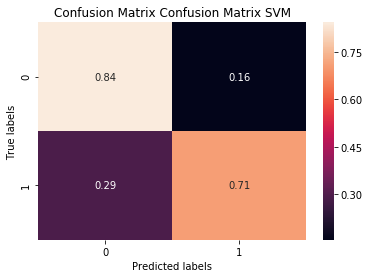

In [0]:
my_confusion_mat(Y_test, Y_pred,'Confusion Matrix SVM','conf_SVM')

### Naive Bayes

In [0]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
model.fit(X_train,Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
Y_pred=model.predict(X_test)

In [0]:
print('Classification_report\n',classification_report(Y_test,Y_pred))

Classification_report
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      4471
           1       0.77      0.72      0.75      3523

   micro avg       0.78      0.78      0.78      7994
   macro avg       0.78      0.78      0.78      7994
weighted avg       0.78      0.78      0.78      7994



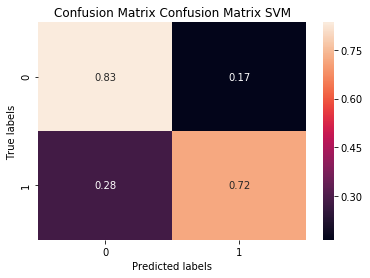

In [0]:
my_confusion_mat(Y_test, Y_pred,'Confusion Matrix SVM','conf_SVM')

### Unsupervised clustering: K-MEANS

In [0]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)
Y_pred = model.fit_predict(X_test)


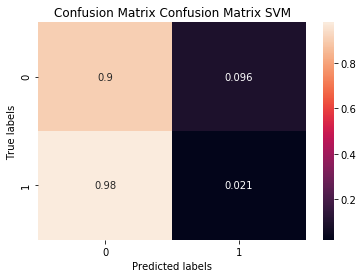

In [0]:
my_confusion_mat(Y_test, Y_pred,'Confusion Matrix SVM','conf_SVM')

PCA + Kmeans

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_test)  
X_pca=pca.transform(X_test) 

In [0]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)
Y_pred = model.fit_predict(X_pca)

Text(0.5, 1.0, 'Predicted labels')

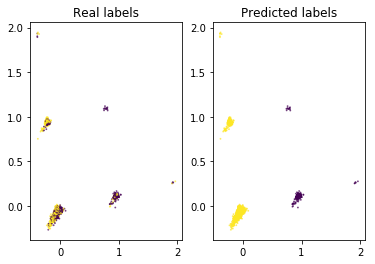

In [0]:
plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_test, alpha=0.6, s=0.8)
plt.title('Real labels')
plt.subplot(122)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=1-Y_pred, alpha=0.6, s=0.8)
plt.title('Predicted labels')

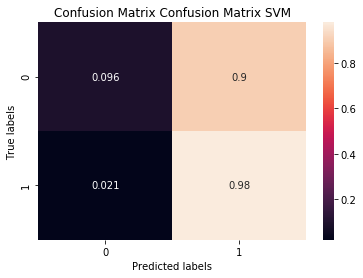

In [0]:
my_confusion_mat(Y_test, 1-Y_pred,'Confusion Matrix SVM','conf_SVM')